# PURPOSE OF THIS NOTEBOOK:
Analyze and determine how much of a gap there is between Max and his second teammate since 2022. This will test my hypothesis that the issues that Checo were facing were a car issue and not an issue of his skill. 

In [ ]:
import pandas as pd
import numpy as np
import fastf1
import fastf1.plotting
import matplotlib as mpl
import timedelta

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [166]:
# Setting consistant variables
year = 2025
wknd = 1
ses = 'Q'
VER = 'VER'
LAW = 'LAW'
colormap = mpl.cm.turbo

In [175]:
# Doing a test run to plot 
session = fastf1.get_session(year, wknd, ses)
session.load()
weekend = session.event

MaxLap = session.laps.pick_drivers(VER).pick_fastest()
LawLap = session.laps.pick_drivers(LAW).pick_fastest()

# Get the telemetry for max
VER_x = MaxLap.telemetry['X']
VER_y = MaxLap.telemetry['Y']
VER_color = MaxLap.telemetry['Throttle']
VER_laptime = MaxLap.telemetry[-1:]
VER_td = timedelta.Timedelta(MaxLap['LapTime'])

# Get telemetry for liam
LAW_x = LawLap.telemetry['X']
LAW_y = LawLap.telemetry['Y']
LAW_color = LawLap.telemetry['Throttle']
LAW_laptime = LawLap.telemetry[-1:]
LAW_td = timedelta.Timedelta(LawLap['LapTime'])

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']


In [176]:
VER_points = np.array([VER_x, VER_y]).T.reshape(-1, 1, 2)
VER_segments = np.concatenate([VER_points[:-1], VER_points[1:]], axis=1)

LAW_points = np.array([LAW_x, LAW_y]).T.reshape(-1, 1, 2)
LAW_segments = np.concatenate([LAW_points[:-1], LAW_points[1:]], axis=1)

In [207]:
# Turn it into a function:
def plot_fastest_lap(segments, lap, color, weekend, driver, laptime):
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
    plt.title(f'{driver} time: {laptime.total.minutes}:{laptime.total.seconds}',
                size=24, loc='right')
    plt.title(f'{weekend.name} {year} - {driver} - Throttle', size=24, loc='left')


    # Adjust margins and turn of axis
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
    ax.axis('off')


    # After this, we plot the data itself.
    # Create background track line
    ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
            color='black', linestyle='-', linewidth=16, zorder=0)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm,
                        linestyle='-', linewidth=5)

    # Set the values used for colormapping
    lc.set_array(color)

    # Merge all line segments together
    line = ax.add_collection(lc)


    # Finally, we create a color bar as a legend.
    cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
    normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
    legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                    orientation="horizontal")


    # Show the plot
    plt.show()
    print(f"{driver} time: {laptime.total.minutes}:{laptime.total.seconds}")

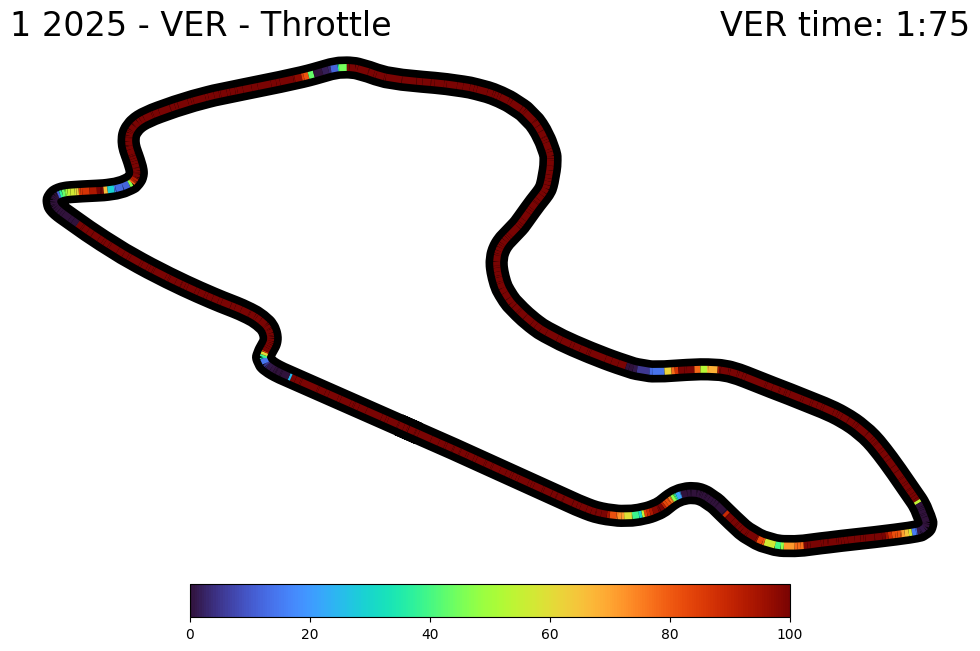

VER time: 1:75


In [208]:
# Plot Max's lap
plot_fastest_lap(VER_segments, MaxLap, VER_color, weekend, VER, VER_td)

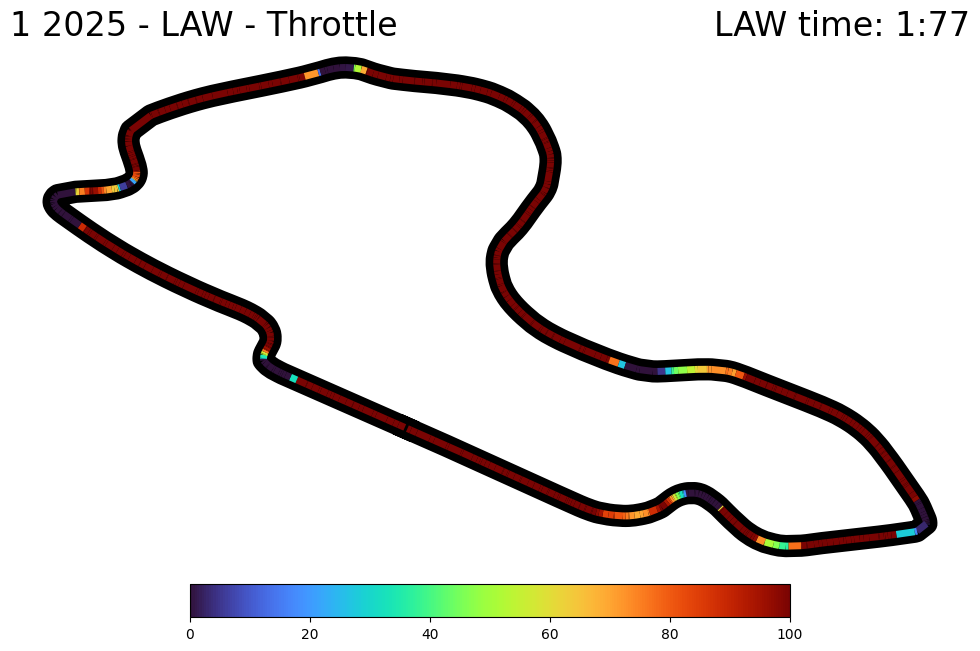

LAW time: 1:77


In [209]:
plot_fastest_lap(LAW_segments, LawLap, LAW_color, weekend, LAW, LAW_td)